# Rubidum Absorption
This notebook is compiles the best measurements of the potassium density from absorption spectroscopy

In [5]:
#import statements
import numpy as np
import matplotlib.pyplot as plt
import one_ring.base.fitting_tools as fitt
import one_ring.base.signal_tools as sit
import one_ring.base.pandas_tools as pdt
import importlib
from one_ring.base.pint_units import ureg
import one_ring.base.h5py_tools as h5t
import scipy.constants
%matplotlib widget
import time as tm
plt.style.use("dark_background")
import pandas as pd
from importlib import reload

### Useful constants

In [6]:
outfname = "../data/hybrid_pumping.h5"
rad_e = scipy.constants.physical_constants['classical electron radius'][0] * ureg.m
c = scipy.constants.c*ureg.m/ureg.s
f_D1 = 0.004

In [7]:
group_name = "olaf_2025_07_25/rb/hot_scan"
data = h5t.load_group(outfname, group_name)
x_range = data['freq']

#filtering out x_range error points, there is none in this dataset
error_mask = x_range.m>-700
x_range = data['freq'][error_mask]

mask_ranges = np.array([(710.783,710.790)])


#initializing a mask that allows all points except for the regions denoted in the mask_range. 
fit_mask = x_range.m > -10000
for i,m in enumerate(mask_ranges):
    L = x_range.m > m[0]
    R = x_range.m < m[1]
    fit_mask *= ~(L*R)
    
h5t.get_node_metadata(outfname, group_name)

{'calib': nan,
 'misc_notes': 'Rb scan with digital piezo scanning. coarse full spectrum scan',
 'piezo scan': array([-5.  ,  0.02,  5.  ]),
 'power_meter_head': 'S120C and S121C',
 'cell_temperature': <Quantity(190, 'degree_Celsius')>,
 'laser_current': <Quantity(0.049, 'ampere')>,
 'laser_temp': <Quantity(11.0, 'degree_Celsius')>,
 'power_meter_wavelength': <Quantity(421, 'nanometer')>}

C:\Users\labuser_L213\miniforge3\envs\one_ring\lib\site-packages\matplotlib\cbook.py:1398: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


710.9616495754816
0.015336341358980104


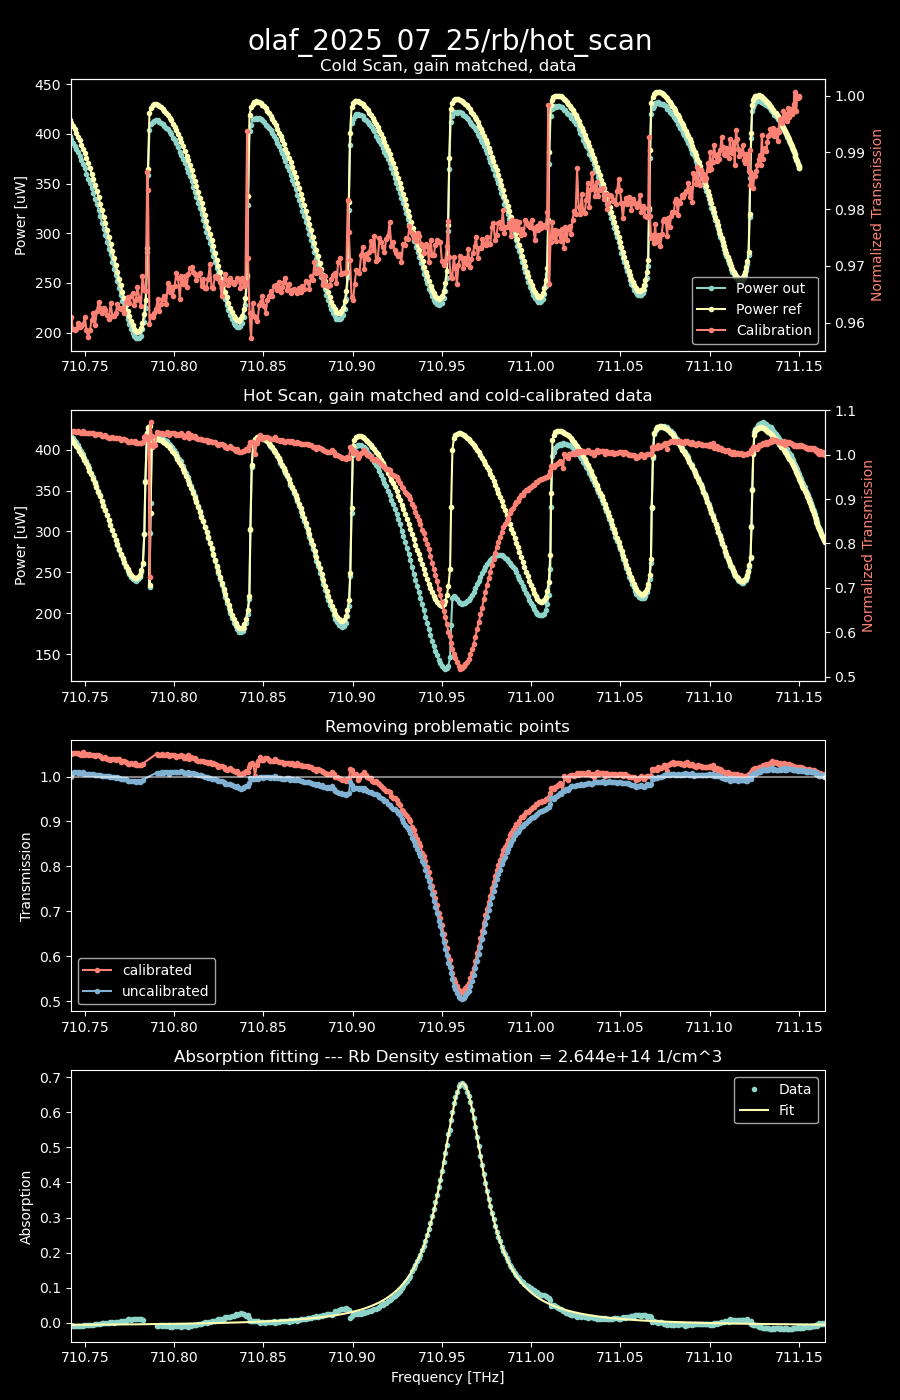

In [8]:
fig, axes = plt.subplots(figsize=(9,14),nrows=4)
ax = axes[0]
ax1 = axes[1]
ax2 = axes[2]
ax3 = axes[3]

#COLD SCAN to get calibration curve--------------------------------
group_name = "olaf_2025_07_25/rb/cold_scan"
data = h5t.load_group(outfname, group_name)
P_hot = data['P_hot'][error_mask]
P_ref = data['P_ref'][error_mask]
x_range = data['freq'][error_mask]

ax00 = ax.twinx()
first_valid_point = np.where(x_range.m == x_range.m[fit_mask][0])
gain_calib = P_hot[first_valid_point] / P_ref[first_valid_point]

lns1 = ax.plot(x_range.m, P_hot.m, label='Power out', marker='.')
lns2 = ax.plot(x_range.m, (P_ref*gain_calib), label='Power ref', marker='.')
lns3 = ax00.plot(x_range.m, P_hot/(P_ref*gain_calib), color='C3', label='Calibration', marker='.' )

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

calibration_curve = P_hot/P_ref/gain_calib

#HOT SCAN---------------------------------------------------------
group_name = "olaf_2025_07_25/rb/hot_scan"
data = h5t.load_group(outfname, group_name)
P_hot = data['P_hot'][error_mask]
P_ref = data['P_ref'][error_mask]
x_range = data['freq'][error_mask]

ax01 = ax1.twinx()
first_valid_point = np.where(x_range.m == x_range.m[fit_mask][0])
gain_calib = P_hot[first_valid_point]/ P_ref[first_valid_point]

lns1 = ax1.plot(x_range.m, P_hot.m, label='Power out', marker='.')
lns2 = ax1.plot(x_range.m, (P_ref*gain_calib), label='Power ref', marker='.')
lns3 = ax01.plot(x_range.m, P_hot/(P_ref*gain_calib)/calibration_curve, color='C3', label='transmission' , marker='.')

#MASK'd SCAN TRANSMISSION
normalized_curve = P_hot/(P_ref*gain_calib)
lns1 = ax2.plot(x_range.m[fit_mask], normalized_curve[fit_mask] / calibration_curve[fit_mask] , label='calibrated', marker='.',color='C3')
lns2 = ax2.plot(x_range.m[fit_mask], normalized_curve[fit_mask], color='C4', label='uncalibrated', marker='.')
lns3 = ax2.axhline(1,alpha=0.5, marker = '.')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=0)

#CONVERTING TO ABSORPTION AND FITTING
#lns1 = ax3.plot(x_range.m[fit_mask], -np.log(normalized_curve[fit_mask]), marker='.')
abs_fitter =fitt.AbsorptiveLorentzianFitter()
fit_result = abs_fitter.fit(x_range.m[fit_mask], -np.log(normalized_curve[fit_mask]).m,guess = [0.07,710.96,0.035,0.00])
fit_result.plot_fit(ax=ax3)
print(fit_result.fit_parameters['f0'])
print(fit_result.fit_parameters['HWHM'])


ax3.set_xlabel('Frequency [THz]')
ax.set_ylabel('Power [uW]')
ax1.set_ylabel('Power [uW]')
ax00.set_ylabel('Normalized Transmission',color='C3')
ax01.set_ylabel('Normalized Transmission',color='C3')
ax2.set_ylabel('Transmission')
ax3.set_ylabel('Absorption')
ax.set_title('Cold Scan, gain matched, data')
ax1.set_title('Hot Scan, gain matched and cold-calibrated data')
ax2.set_title('Removing problematic points')

ax.set_xlim(left=data['freq'][-1].m,right=data['freq'][0].m)
ax1.set_xlim(left=data['freq'][-1].m,right=data['freq'][0].m)
ax2.set_xlim(left=data['freq'][-1].m,right=data['freq'][0].m)
ax3.set_xlim(left=data['freq'][-1].m,right=data['freq'][0].m)


#DENSITY CALCULATION
HWHM_freq = ureg.Quantity(fit_result.fit_parameters['HWHM'],ureg.THz)
c = scipy.constants.c*ureg.m/ureg.s
f_rb = 0.004 #according to NIST and chatGPT
cross_section_on_resonance = c*rad_e*f_rb/ (HWHM_freq)  #fixing signage
L = 11.87 * ureg.mm
absorbance_resonance = fit_result.fit_parameters['A'] / fit_result.fit_parameters['HWHM']
density_K = absorbance_resonance / (L * cross_section_on_resonance)

ax3.set_title('Absorption fitting --- Rb Density estimation = {:.3e} 1/cm^3'.format(density_K.to(1/ureg.cm**3).m))
plt.suptitle(group_name,fontsize=20)
plt.tight_layout()
plt.show()

{'A': 0.01060623711792844, 'f0': 710.9616495754816, 'HWHM': 0.015336341358980104, 'Offset': -0.009188797847176482}
{'A': 4.4390629311358545e-05, 'f0': 5.082268425979213e-05, 'HWHM': 8.143893698509562e-05, 'Offset': 0.00047398912018006324}


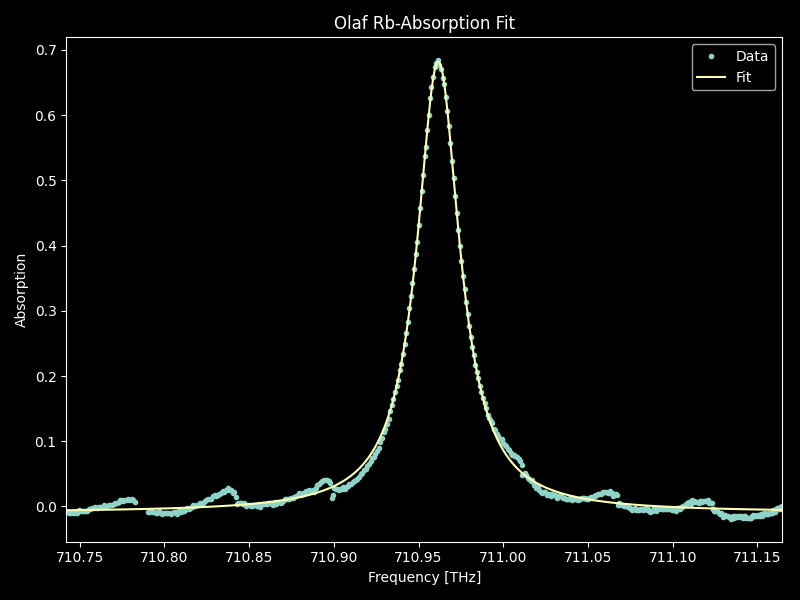

In [16]:
fig, ax = plt.subplots(figsize=(8,6))


#COLD SCAN to get calibration curve--------------------------------
group_name = "olaf_2025_07_25/rb/cold_scan"
data = h5t.load_group(outfname, group_name)
P_hot = data['P_hot'][error_mask]
P_ref = data['P_ref'][error_mask]
x_range = data['freq'][error_mask]

#ax00 = ax.twinx()
first_valid_point = np.where(x_range.m == x_range.m[fit_mask][0])
gain_calib = P_hot[first_valid_point] / P_ref[first_valid_point]

#lns1 = ax.plot(x_range.m, P_hot.m, label='Power out', marker='.')
#lns2 = ax.plot(x_range.m, (P_ref*gain_calib), label='Power ref', marker='.')
#lns3 = ax00.plot(x_range.m, P_hot/(P_ref*gain_calib), color='C3', label='Calibration', marker='.' )

#lns = lns1+lns2+lns3
#labs = [l.get_label() for l in lns]
#ax.legend(lns, labs, loc=0)

calibration_curve = P_hot/P_ref/gain_calib

#HOT SCAN---------------------------------------------------------
group_name = "olaf_2025_07_25/rb/hot_scan"
data = h5t.load_group(outfname, group_name)
P_hot = data['P_hot'][error_mask]
P_ref = data['P_ref'][error_mask]
x_range = data['freq'][error_mask]

#ax01 = ax1.twinx()
first_valid_point = np.where(x_range.m == x_range.m[fit_mask][0])
gain_calib = P_hot[first_valid_point]/ P_ref[first_valid_point]

#MASK'd SCAN TRANSMISSION
normalized_curve = P_hot/(P_ref*gain_calib)

#CONVERTING TO ABSORPTION AND FITTING
abs_fitter =fitt.AbsorptiveLorentzianFitter()
fit_result = abs_fitter.fit(x_range.m[fit_mask], -np.log(normalized_curve[fit_mask]).m,guess = [0.07,710.96,0.035,0.00])
fit_result.plot_fit(ax=ax)

print(fit_result.fit_parameters)
print(fit_result.fit_error)

ax.set_xlim(left=data['freq'][-1].m,right=data['freq'][0].m)
ax1.set_xlim(left=data['freq'][-1].m,right=data['freq'][0].m)
ax2.set_xlim(left=data['freq'][-1].m,right=data['freq'][0].m)
ax3.set_xlim(left=data['freq'][-1].m,right=data['freq'][0].m)


#DENSITY CALCULATION
HWHM_freq = ureg.Quantity(fit_result.fit_parameters['HWHM'],ureg.THz)
c = scipy.constants.c*ureg.m/ureg.s
f_rb = 0.004 #according to NIST and chatGPT
cross_section_on_resonance = c*rad_e*f_rb/ (HWHM_freq)  #fixing signage
L = 1 * ureg.cm
absorbance_resonance = fit_result.fit_parameters['A'] / fit_result.fit_parameters['HWHM']
density_K = absorbance_resonance / (L * cross_section_on_resonance)

plt.title('Olaf Rb-Absorption Fit')
plt.xlabel('Frequency [THz]')
plt.ylabel('Absorption')
plt.tight_layout()
plt.show()

In [24]:
print('{:.3e}'.format(density_K.to(ureg.cm**-3)))

2.644e+14 / centimeter ** 3
